In [1]:
# 01. Exploratory Data Analysis (EDA)
#**Dataset:** Fake and Real News  
#**Author:** _Lucas Garcia_  
#**Date:** _2025-07-04_


In [2]:
# General libraries
import os
import pandas as pd
import numpy as np

# For plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# Plot settings
%matplotlib inline
sns.set(style='whitegrid')


In [3]:
# Define file paths
DATA_DIR = "../data/raw"
FAKE_CSV = os.path.join(DATA_DIR, "Fake.csv")
REAL_CSV = os.path.join(DATA_DIR, "True.csv")

# Read CSV files
fake_df = pd.read_csv(FAKE_CSV)
real_df = pd.read_csv(REAL_CSV)

# Add label column
fake_df['label'] = 'fake'
real_df['label'] = 'real'

# Concatenate into a single DataFrame
df = pd.concat([fake_df, real_df], ignore_index=True)
df['full_text'] = df['title'].fillna('') + ' ' + df['text'].fillna('')


In [4]:
# Inspect shapes
print("Fake shape:", fake_df.shape)
print("Real shape:", real_df.shape)
print("Total shape:", df.shape)

# Display first rows
df.head(5)


Fake shape: (23481, 5)
Real shape: (21417, 5)
Total shape: (44898, 6)


,title,text,subject,date,label,full_text
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",fake,Donald Trump Sends Out Embarrassing New Year’...
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",fake,Drunk Bragging Trump Staffer Started Russian ...
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",fake,Sheriff David Clarke Becomes An Internet Joke...
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",fake,Trump Is So Obsessed He Even Has Obama’s Name...
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",fake,Pope Francis Just Called Out Donald Trump Dur...


In [5]:
# Count missing values per column
print("Missing values per column:\n", df.isnull().sum())

# Count duplicate rows
dup_count = df.duplicated().sum()
print(f"Number of duplicate rows: {dup_count}")


Missing values per column:
 title        0
text         0
subject      0
date         0
label        0
full_text    0
dtype: int64
Number of duplicate rows: 209


label
fake    23481
real    21417
Name: count, dtype: int64


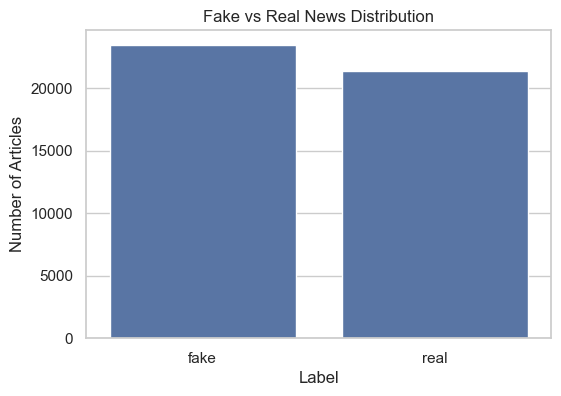

In [6]:
# Count labels
label_counts = df['label'].value_counts()
print(label_counts)

# Plot class distribution
plt.figure(figsize=(6,4))
sns.barplot(x=label_counts.index, y=label_counts.values)
plt.title("Fake vs Real News Distribution")
plt.xlabel("Label")
plt.ylabel("Number of Articles")
plt.show()


In [7]:
# Calculate combined text length (number of words in title+body)
df['full_text_len'] = df['full_text'].apply(lambda t: len(str(t).split()))

# Display descriptive statistics for the new field
df['full_text_len'].describe()


count    44898.000000
mean       417.735757
std        351.480777
min          2.000000
25%        216.000000
50%        375.000000
75%        526.000000
max       8148.000000
Name: full_text_len, dtype: float64

In [8]:
import nltk

# Download once, up front
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\lukgg\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\lukgg\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\lukgg\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [9]:
import re
from nltk.corpus import stopwords

# Initialize stopwords set
stop_words = set(stopwords.words('english'))

def clean_text_no_stem(text):
    # Lowercase
    text = text.lower()
    # Remove non-alphabetic characters (keep spaces)
    text = re.sub(r'[^a-z\s]', ' ', text)
    # Split on whitespace
    tokens = text.split()
    # Remove stopwords
    tokens = [t for t in tokens if t not in stop_words]
    # Rejoin back to string
    return ' '.join(tokens)

# Apply cleaning without stemming
df['clean_full_text'] = df['full_text'].apply(clean_text_no_stem)


# Show a quick peek
df[['full_text','clean_full_text']].head(3)


,full_text,clean_full_text
0,Donald Trump Sends Out Embarrassing New Year’...,donald trump sends embarrassing new year eve m...
1,Drunk Bragging Trump Staffer Started Russian ...,drunk bragging trump staffer started russian c...
2,Sheriff David Clarke Becomes An Internet Joke...,sheriff david clarke becomes internet joke thr...


In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

# TF-IDF vectorization on the combined title+body
tfidf = TfidfVectorizer(max_features=5000)  # adjust if needed
X = tfidf.fit_transform(df['clean_full_text'])  

# Labels: map fake/real a 0/1
y = df['label'].map({'fake': 0, 'real': 1})

# Split train/validation/test: 70/15/15
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp
)

print("Train shape:", X_train.shape)
print("Validation shape:", X_val.shape)
print("Test shape:", X_test.shape)


Train shape: (31428, 5000)
Validation shape: (6735, 5000)
Test shape: (6735, 5000)


In [11]:
# Baseline model: Multinomial Naive Bayes
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score

# Instantiate and train
nb = MultinomialNB()
nb.fit(X_train, y_train)

# Predict on validation set
y_pred_nb = nb.predict(X_val)

# Metrics
print("Naive Bayes Validation Accuracy:", accuracy_score(y_val, y_pred_nb))
print("Naive Bayes Validation F1-score:", f1_score(y_val, y_pred_nb))
print("\nClassification Report:\n", classification_report(y_val, y_pred_nb))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_pred_nb))


Naive Bayes Validation Accuracy: 0.9330363771343727
Naive Bayes Validation F1-score: 0.9299363057324841

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.93      0.94      3522
           1       0.93      0.93      0.93      3213

    accuracy                           0.93      6735
   macro avg       0.93      0.93      0.93      6735
weighted avg       0.93      0.93      0.93      6735

Confusion Matrix:
 [[3291  231]
 [ 220 2993]]


In [12]:
# Baseline model: Logistic Regression
from sklearn.linear_model import LogisticRegression

# Instantiate and train
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)

# Predict on validation set
y_pred_lr = lr.predict(X_val)

# Metrics
print("Logistic Regression Validation Accuracy:", accuracy_score(y_val, y_pred_lr))
print("Logistic Regression Validation F1-score:", f1_score(y_val, y_pred_lr))
print("\nClassification Report:\n", classification_report(y_val, y_pred_lr))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_pred_lr))


Logistic Regression Validation Accuracy: 0.9881217520415738
Logistic Regression Validation F1-score: 0.9875930521091811

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99      3522
           1       0.98      0.99      0.99      3213

    accuracy                           0.99      6735
   macro avg       0.99      0.99      0.99      6735
weighted avg       0.99      0.99      0.99      6735

Confusion Matrix:
 [[3471   51]
 [  29 3184]]


In [13]:
from sklearn.model_selection import GridSearchCV

# Define parameter grid
param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear'],   # compatible con l1 y l2
}

# Set up GridSearchCV
grid_lr = GridSearchCV(
    estimator=LogisticRegression(max_iter=1000),
    param_grid=param_grid,
    scoring='f1',
    cv=5,
    n_jobs=-1,
    verbose=1
)

# Run grid search
grid_lr.fit(X_train, y_train)

# Best parameters and score
print("Best params:", grid_lr.best_params_)
print("Best CV F1-score:", grid_lr.best_score_)


Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best params: {'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}
Best CV F1-score: 0.995330419977851


In [14]:
# Use the best estimator from grid search
best_lr = grid_lr.best_estimator_

# Validation metrics
y_val_pred = best_lr.predict(X_val)
print("Tuned LR Validation F1-score:", f1_score(y_val, y_val_pred))

# Test metrics
y_test_pred = best_lr.predict(X_test)
print("Tuned LR Test Accuracy:", accuracy_score(y_test, y_test_pred))
print("Tuned LR Test F1-score:", f1_score(y_test, y_test_pred))
print("\nTest Classification Report:\n", classification_report(y_test, y_test_pred))


Tuned LR Validation F1-score: 0.996571072319202
Tuned LR Test Accuracy: 0.9967334818114328
Tuned LR Test F1-score: 0.9965732087227415

Test Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      3523
           1       1.00      1.00      1.00      3212

    accuracy                           1.00      6735
   macro avg       1.00      1.00      1.00      6735
weighted avg       1.00      1.00      1.00      6735



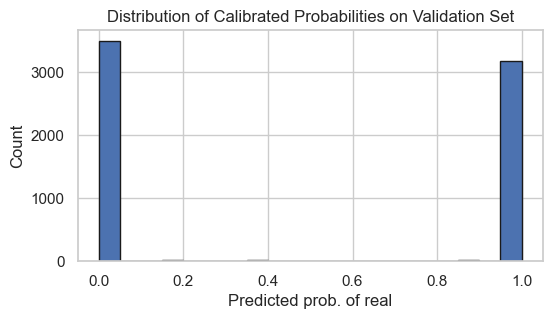

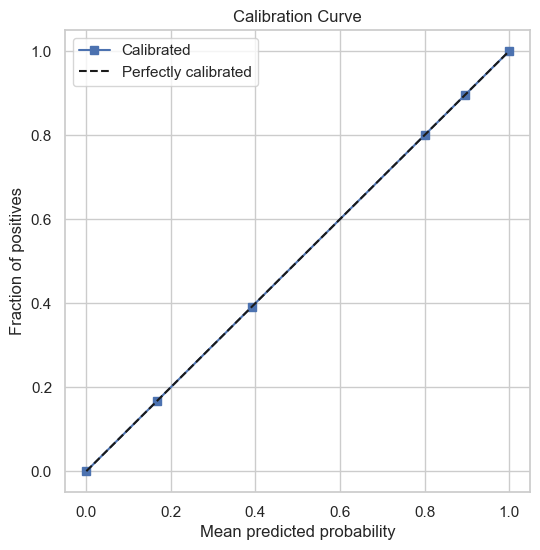

Using threshold = 0.7
Calibrated Test F1-score: 0.9967294813891917

Test Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      3523
           1       1.00      1.00      1.00      3212

    accuracy                           1.00      6735
   macro avg       1.00      1.00      1.00      6735
weighted avg       1.00      1.00      1.00      6735

fake (p=0.00): The Federal Reserve raised interest rates by 25 basis points today, marking the third consecutive hike this year.
fake (p=0.00): Local health officials report that vaccination rates have reached a record high this quarter.


In [ ]:
# 15. Calibration of the best Logistic Regression
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
import matplotlib.pyplot as plt

# Fit Platt scaling on the validation set
calibrator = CalibratedClassifierCV(best_lr, method='isotonic', cv='prefit')

calibrator.fit(X_val, y_val)


probs_val = calibrator.predict_proba(X_val)[:,1]
plt.figure(figsize=(6,3))
plt.hist(probs_val, bins=20, edgecolor='k')
plt.title("Distribution of Calibrated Probabilities on Validation Set")
plt.xlabel("Predicted prob. of real")
plt.ylabel("Count")
plt.show()

# Plot reliability diagram
prob_true, prob_pred = calibration_curve(
    y_val,
    calibrator.predict_proba(X_val)[:,1],
    n_bins=10
)
plt.figure(figsize=(6,6))
plt.plot(prob_pred, prob_true, 's-', label="Calibrated")
plt.plot([0,1], [0,1], 'k--', label="Perfectly calibrated")
plt.xlabel("Mean predicted probability")
plt.ylabel("Fraction of positives")
plt.title("Calibration Curve")
plt.legend()
plt.show()

 # 16. Evaluate the calibrated model on the test set
from sklearn.metrics import f1_score, classification_report

threshold = 0.7
y_test_prob_cal = calibrator.predict_proba(X_test)[:,1]
y_test_pred_cal = (y_test_prob_cal >= threshold).astype(int)


print(f"Using threshold = {threshold}")
print("Calibrated Test F1-score:", f1_score(y_test, y_test_pred_cal))
print("\nTest Classification Report:\n", classification_report(y_test, y_test_pred_cal))
# 17. Try the “real” examples again with the calibrated model
samples = [
     "The Federal Reserve raised interest rates by 25 basis points today, marking the third consecutive hike this year.",
     "Local health officials report that vaccination rates have reached a record high this quarter."
 ]
probs = calibrator.predict_proba(tfidf.transform(samples))[:,1]

for text, p in zip(samples, probs):
    # we use the same threshold as before
    label = 'real' if p >= threshold else 'fake'
    print(f"{label} (p={p:.2f}): {text}")

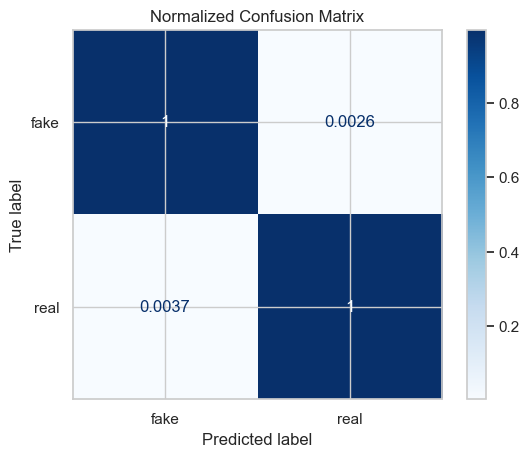

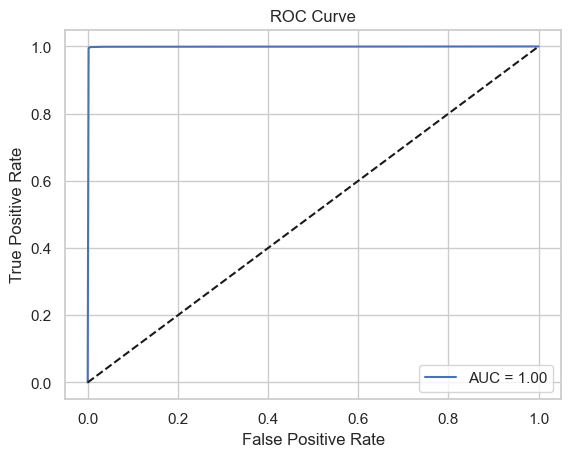

In [16]:
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay, roc_curve, auc

final_model = calibrator 
# 1) Confusion matrix (normalized)
ConfusionMatrixDisplay.from_estimator(
    final_model,
    X_test,
    y_test,
    display_labels=['fake', 'real'],
    cmap=plt.cm.Blues,
    normalize='true'
)
plt.title("Normalized Confusion Matrix")
plt.show()

# 2) ROC curve and AUC
# First get probabilities and compute fpr/tpr/auc
y_prob = final_model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC
plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()


In [17]:
import os

# Create models directory if it doesn't exist
os.makedirs('../models', exist_ok=True)



In [18]:
import joblib

# Save TF-IDF vectorizer
joblib.dump(tfidf,    '../models/tfidf_vectorizer.joblib')

# Save final model
joblib.dump(final_model, '../models/final_fake_news_model.joblib')

['../models/final_fake_news_model.joblib']